# Structured RerF Demo

Similar to figure 13 [here](https://arxiv.org/pdf/1506.03410v4.pdf) we create a 
distribution of 28x28 pixel images with randomly spaced and sized bars. 

In class 0 the bars are oriented horizontally and in class 1 the bars are oriented vertically.

We compare the error-counting estimator $\hat{L}_{n,m}$ for $n \in \{10, 20, \dots, 1000\}$ and $m=10000$ over S-RerF, RerF, and a few other classification algorithms. 





In [15]:
%matplotlib inline
import gc
import math
import pandas as pd
import numpy as np
import time, multiprocessing
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import seaborn as sns

from rerf.RerF import fastPredict, fastPredictPost, fastRerF
from rerf.rerfClassifier import rerfClassifier

from scipy.stats import bernoulli
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

gc.enable()

import warnings
warnings.simplefilter('ignore')

In [8]:
def genHV(h = 28, w = 28, lambda_ = 10, num_samples = 10, prob = 0.5):
    num_bars = np.random.poisson(lam = lambda_, size = num_samples)

    loc = [np.random.randint(0, h, nbi) for nbi in num_bars]
    
    #cls = bernoulli.rvs(p = prob, size = num_samples)
    #classLabel = [0 for _ in range(int(num_samples / 2))] +\
    #        [1 for _ in range(int(num_samples / 2))]

    # Y = [0,1,0,1,0,1,...]
    classLabel = [0,1] * int(num_samples / 2)

    out = []
    for i in range(num_samples):
        X = np.zeros(h * w).reshape(h, w)
        for j in loc[i]:
            X[j, :] = 1

        out.append(X)
            
    for ci in range(len(classLabel)):
        if classLabel[ci] == 1:
            out[ci] = np.transpose(out[ci])

    #out = np.asarray([outi.flatten() for outi in out])
    out = np.asarray([outi.flatten() for outi in out])

    return out, classLabel

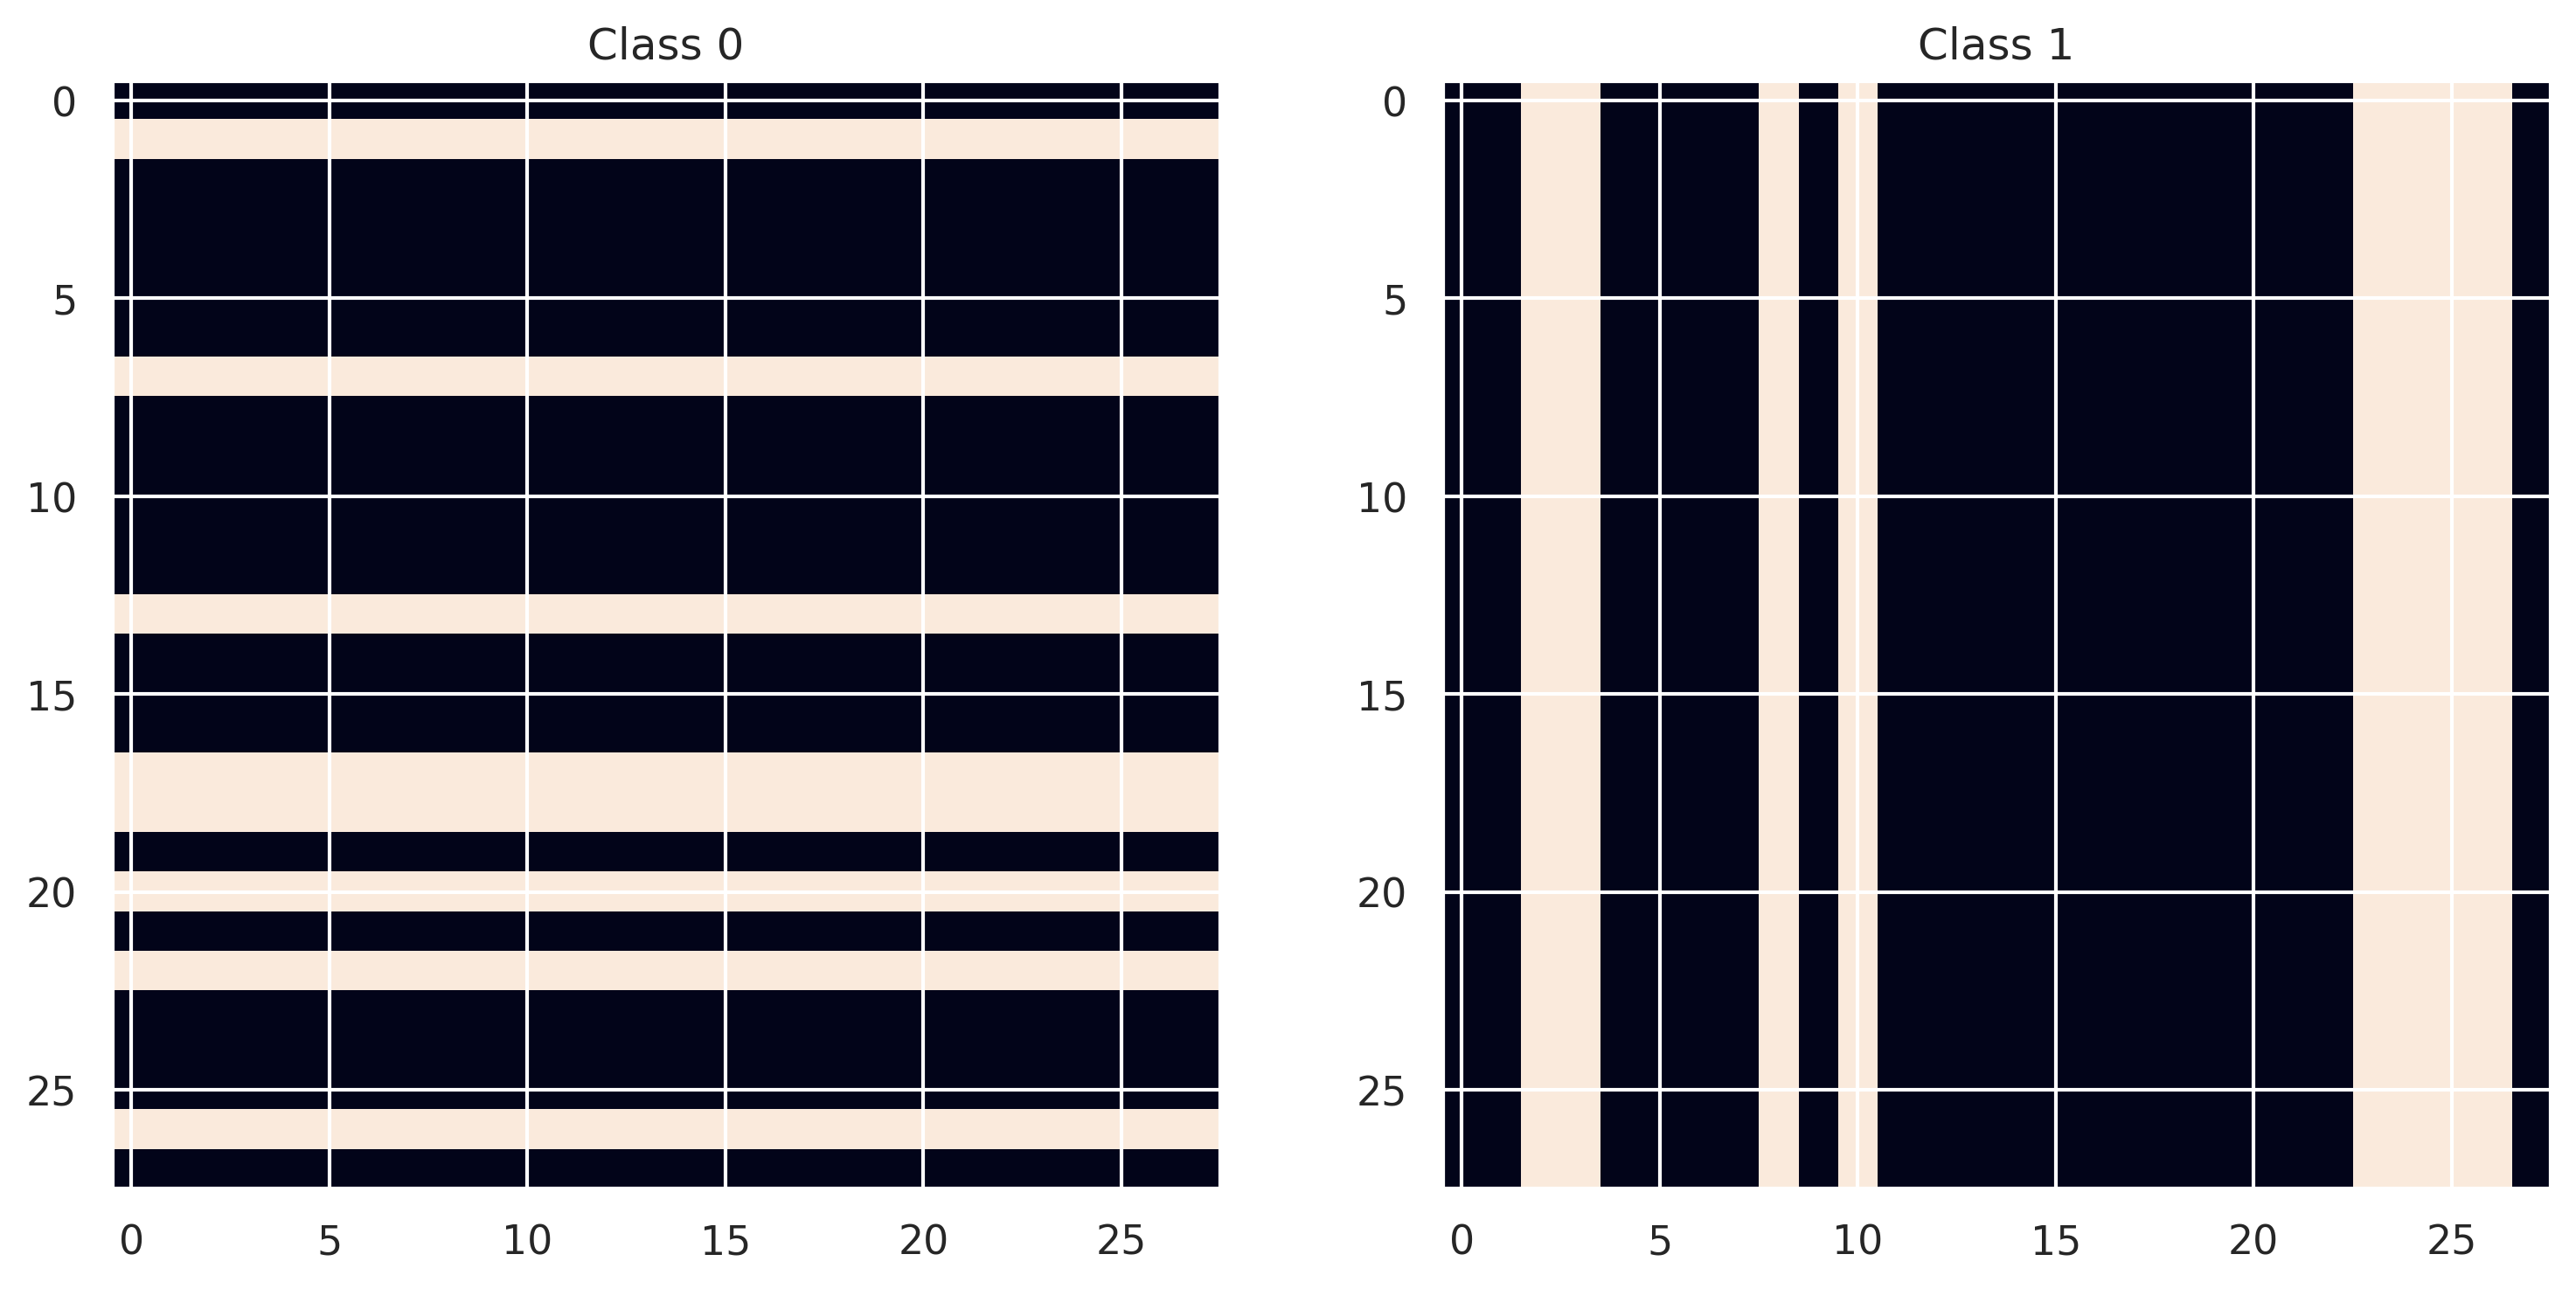

In [27]:
rng = np.random.RandomState(4)

ns = np.array([10,25,50,100,200])

X_train, Y_train = genHV(num_samples = ns[-1])
X_test, Y_test = genHV(num_samples = 10000)
plt.subplot(1,2,1)
plt.imshow(X_train[0, :].reshape(28,28))
plt.title("Class 0")
plt.subplot(1,2,2)
plt.imshow(X_train[1, :].reshape(28,28))
plt.title("Class 1")
plt.show()

In [28]:
## Setup for run
names = {"kNN": "black", 
         "RF":"#f86000", "MLP":"green", "RerF":"cyan", "S-RerF":"red"}

ncores=1
num_runs=1
n_est=100

classifiers = [
    #SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features=28, n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=500),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
        max_features = 28, n_jobs = ncores),
    rerfClassifier(
        projection_matrix="S-RerF", 
        max_features = 28,
        n_estimators=n_est,
        n_jobs=ncores,
        image_height=28, 
        image_width=28, 
        patch_height_max=4,
        patch_width_max=1,
        patch_height_min=4,
        patch_width_min=1,
        )
    ]

In [29]:
# iterate
## Prep output file:
with open('s-rerf_runs.csv', 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")

runList = [(n, clf, iterate) for n in ns\
                             for clf in zip(classifiers, [key for key in names])\
                             for iterate in range(1, num_runs + 1)]

for n, clf, iterate in tqdm(runList):
        #print(f"iterate: {iterate}\t n: {n}\t classifier: {clf[1]}")
        gc.collect()
        X = X_train[0:n, ::]
        y = Y_train[0:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        with open('s-rerf_runs.csv', 'a') as f:
            f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")
            
        gc.collect()

100%|██████████| 25/25 [00:30<00:00,  1.44s/it]


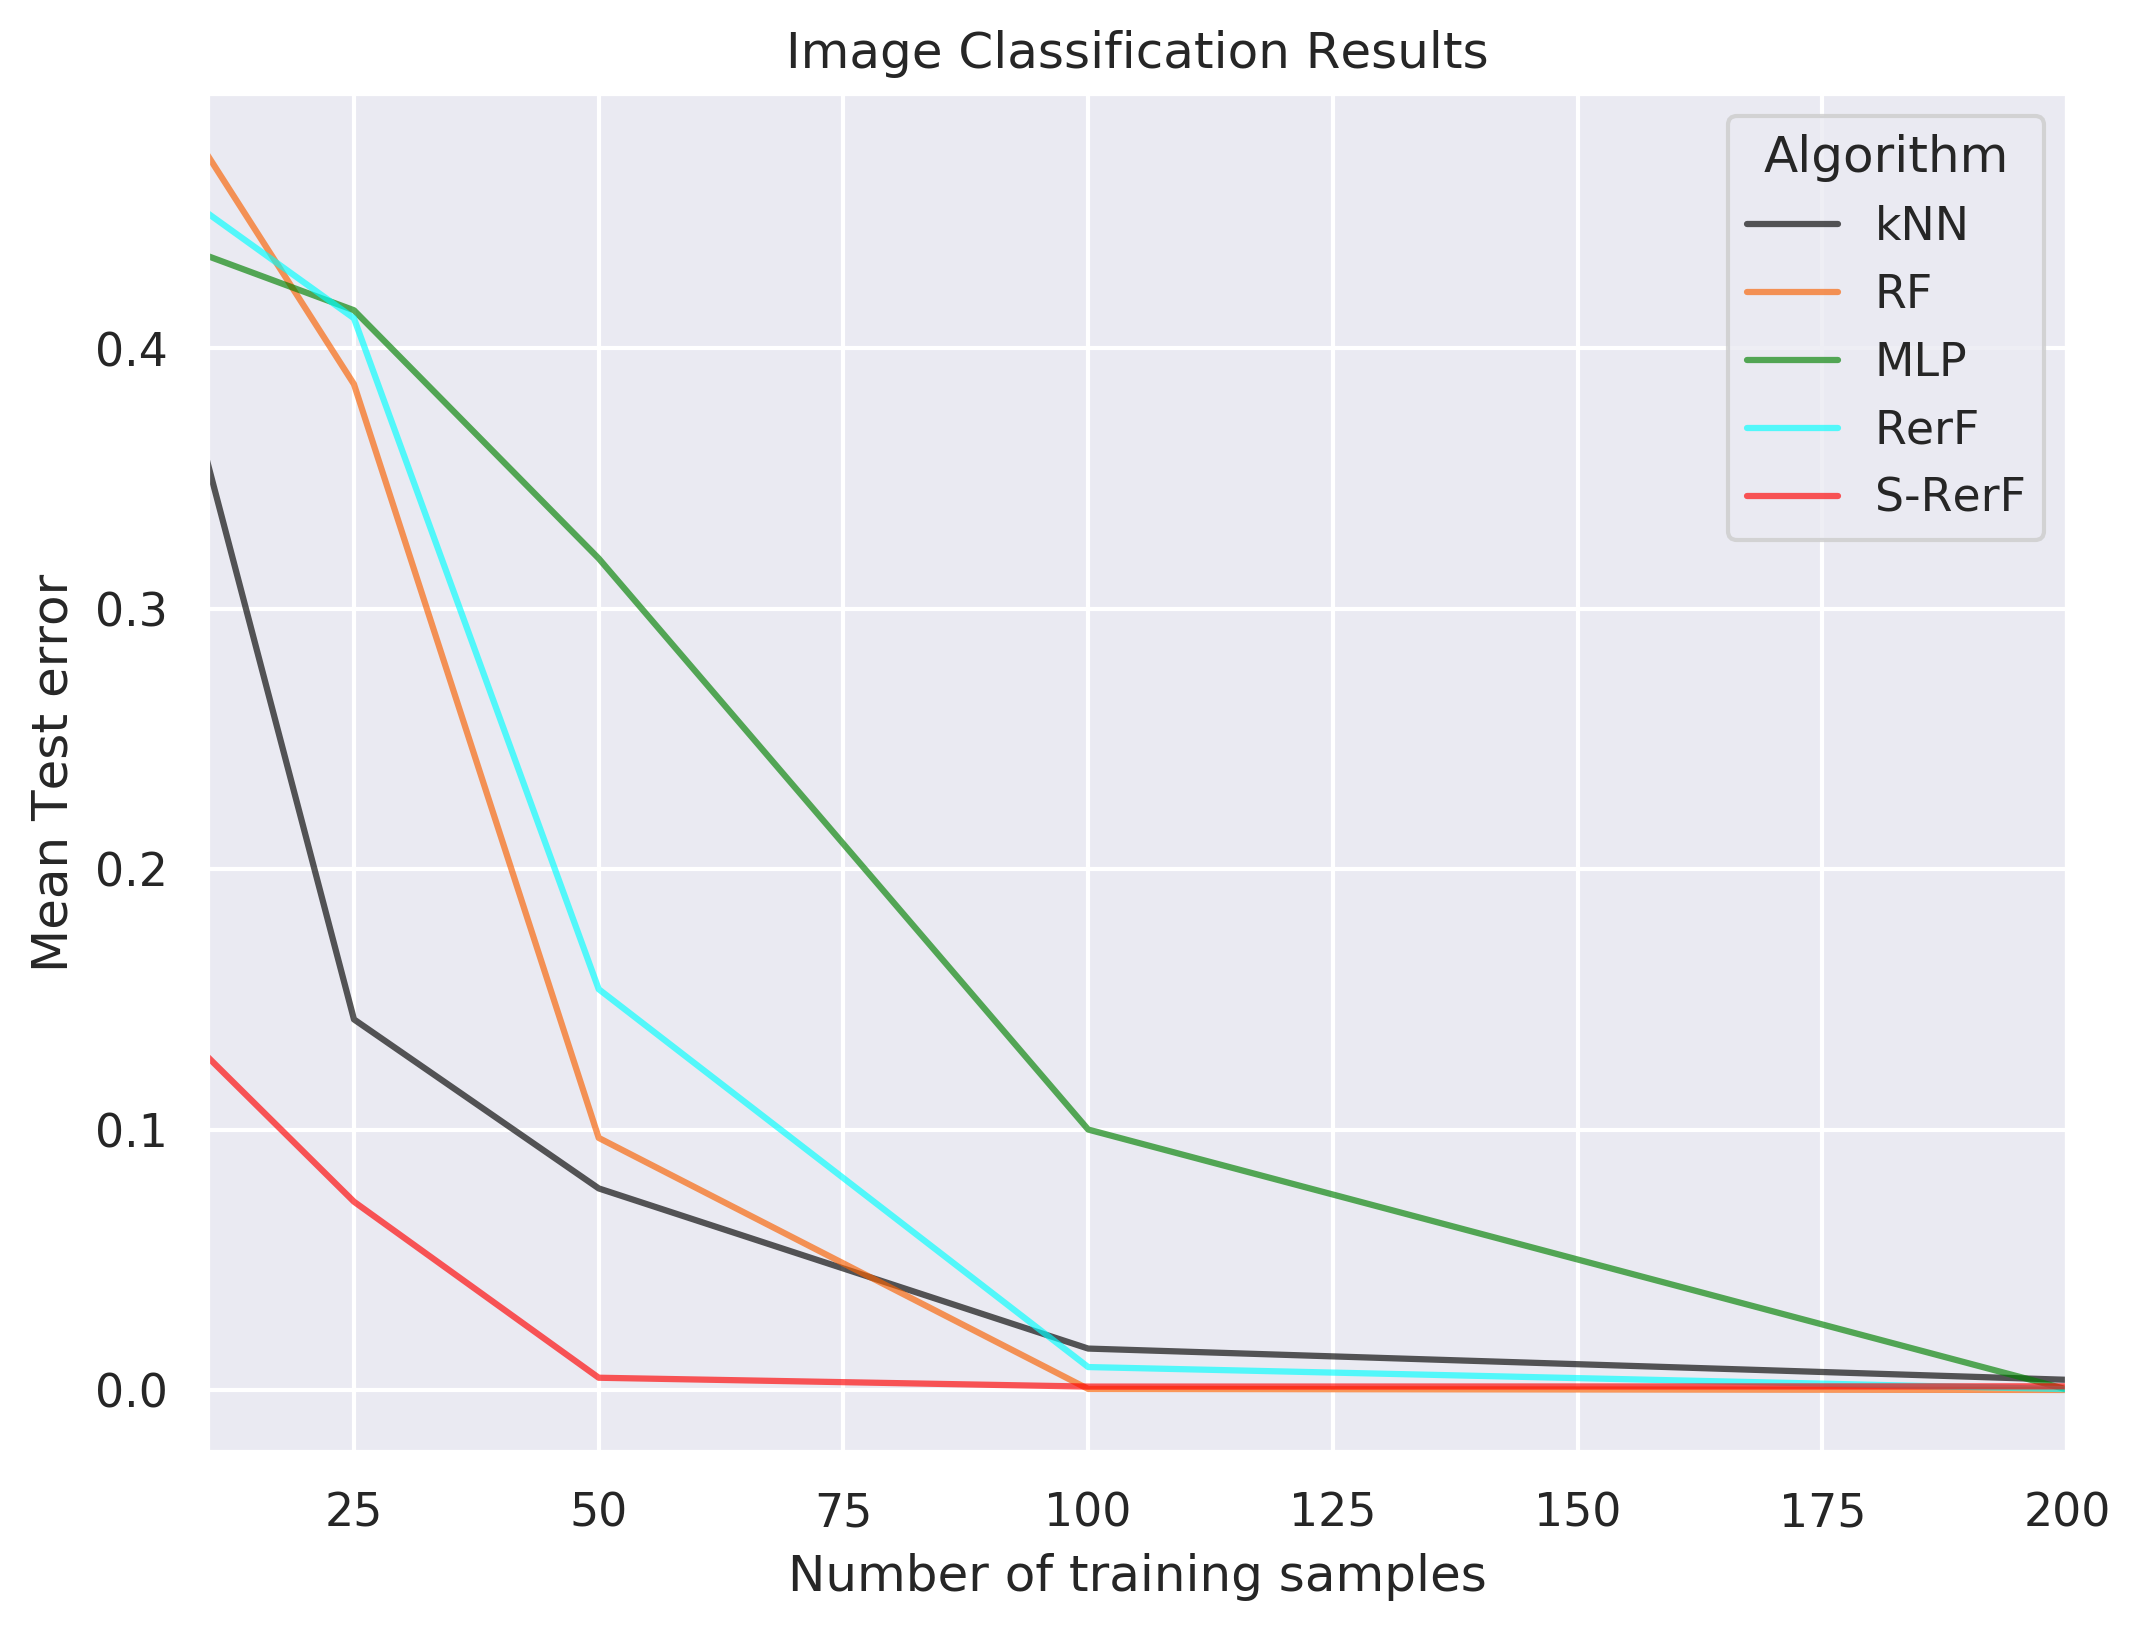

In [30]:
dat = pd.read_csv("s-rerf_runs.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])
#d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):
        if not cl in names.keys():
            continue

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])
        
        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})        
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key] 
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='upper right',title='Algorithm')
plt.title('Image Classification Results')
plt.ylabel('Mean test error')
plt.xlabel('Number of training samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()

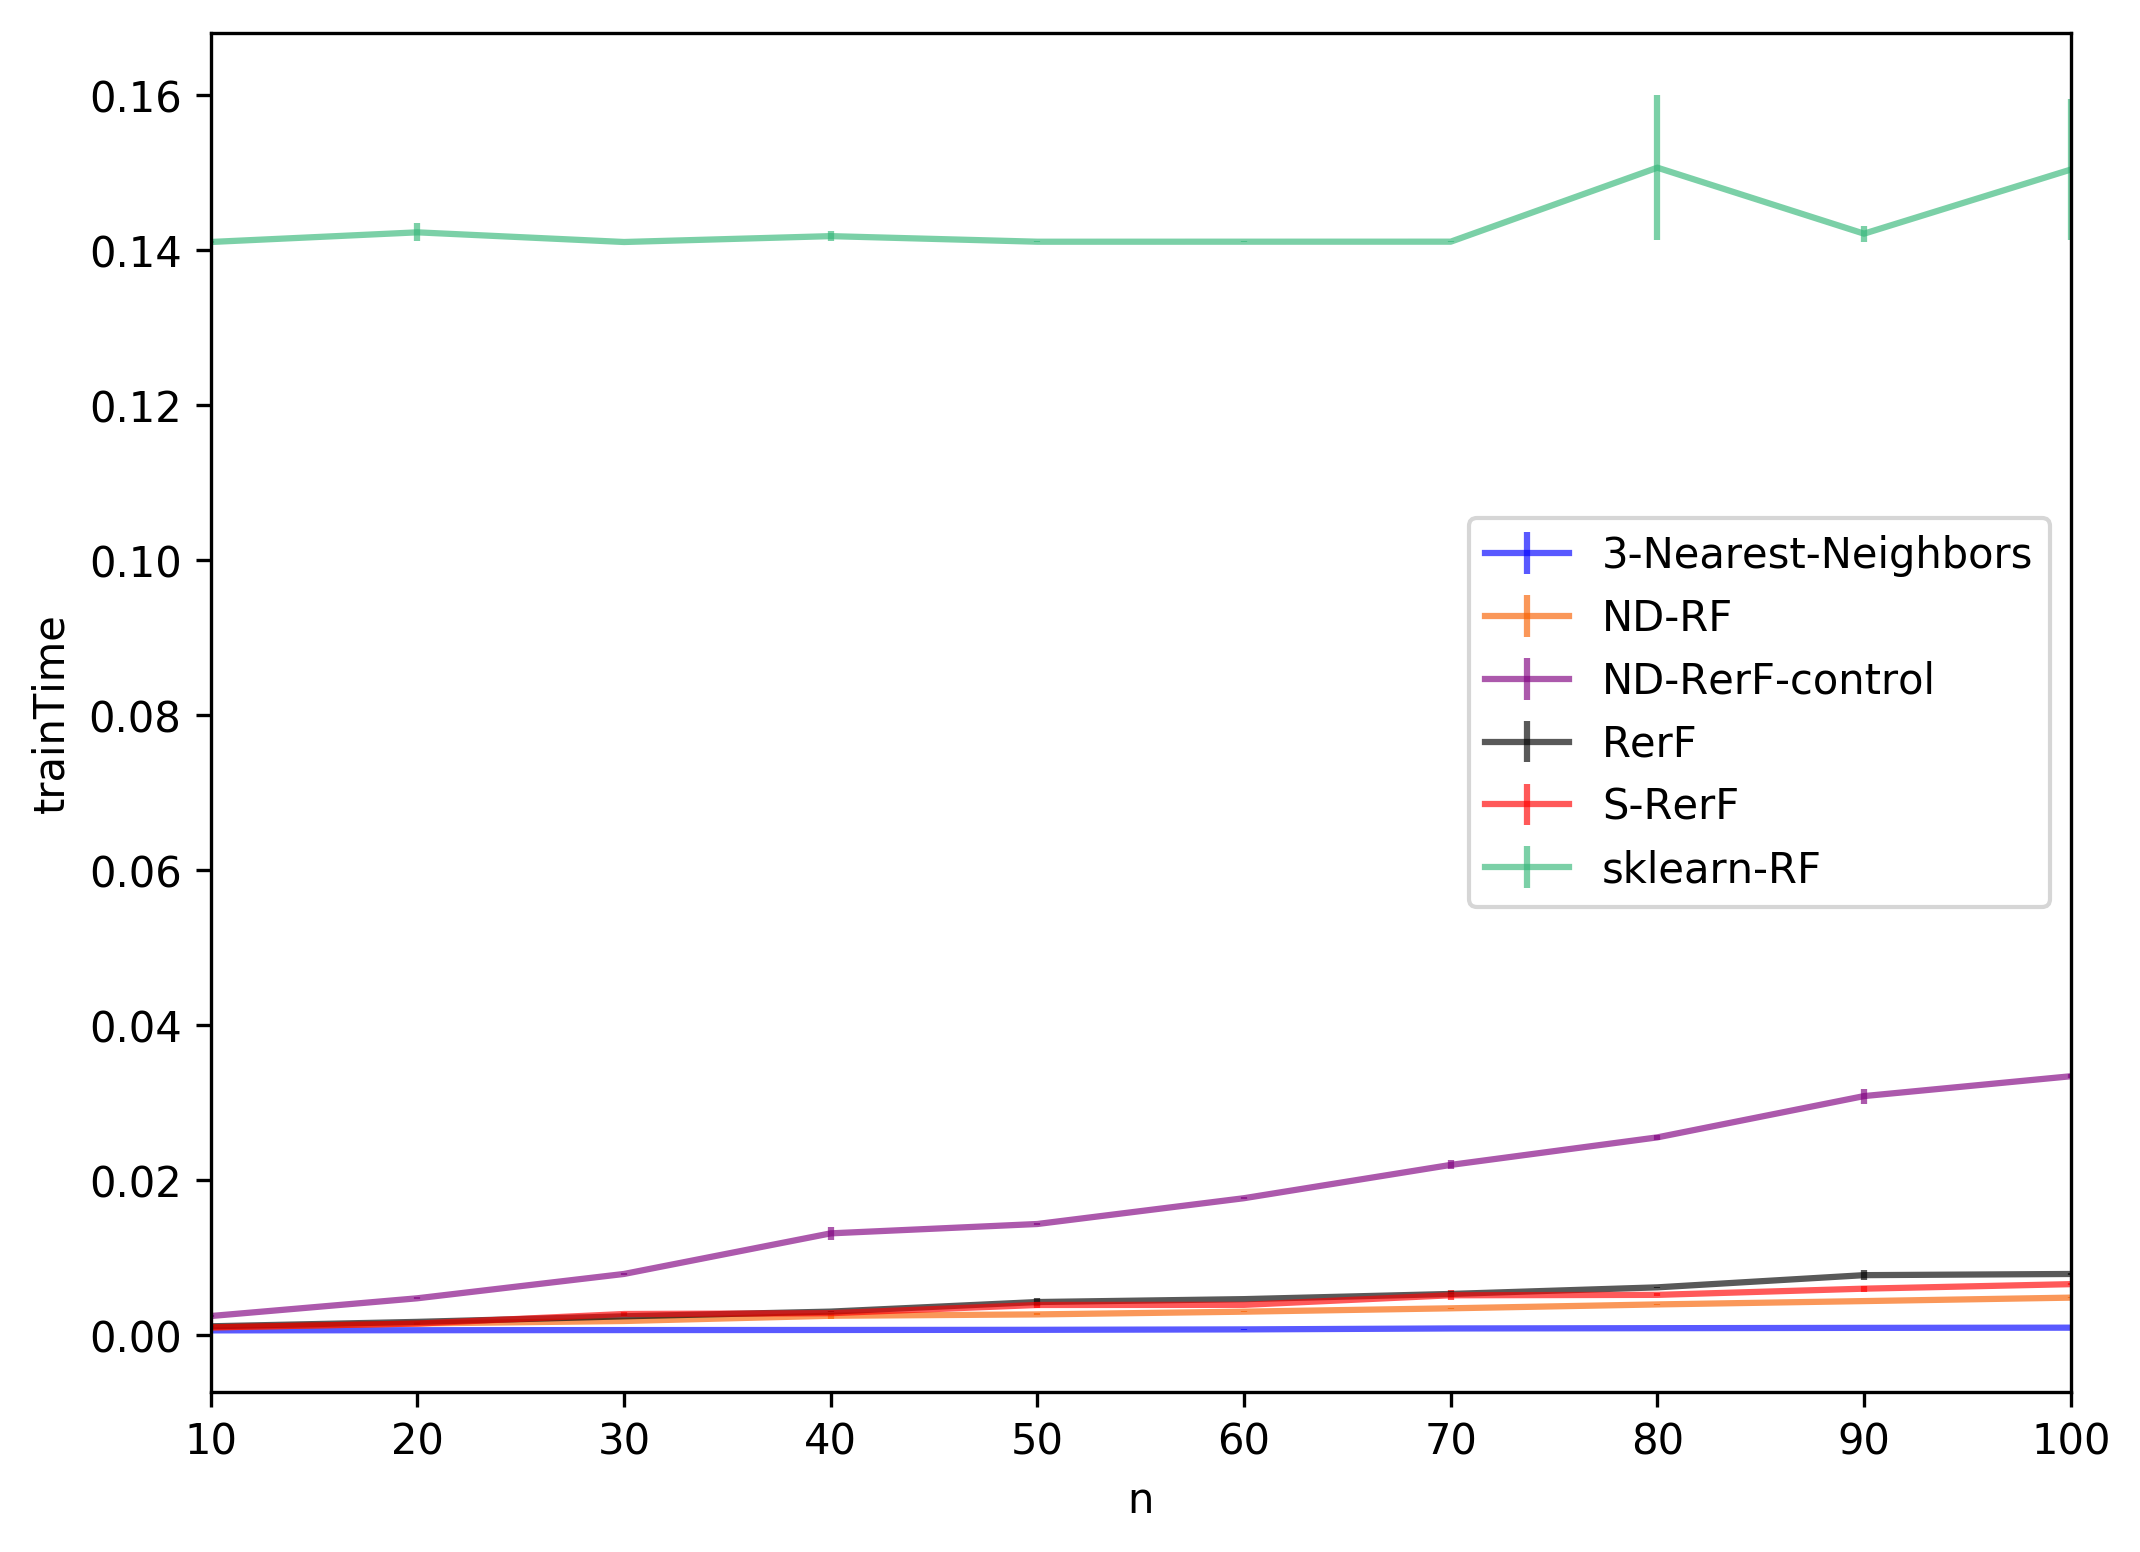

In [12]:
d1 = pd.DataFrame(columns = ['classifier', 'n', 'trainTime', 'se', 'color'])

k = 0
for ni in np.unique(dat['n'])[0:10]:
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'trainTime']]

        se = stats.sem(tmp['trainTime'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        k += 1

 
matplotlib.rc('figure', figsize=[12,8], dpi = 300)
fig, ax = plt.subplots(figsize = (8,6))

for key, grp in d1.groupby(['classifier']):
    ax = grp.plot(ax=ax, kind='line', x='n', y='trainTime', label=key, \
            c = names[key], yerr='se', alpha =0.65)
    #ax.set_xscale('log', basex=2)
    #ax.set_yscale('log')

plt.legend(loc='best')
plt.ylabel("trainTime")
plt.show()

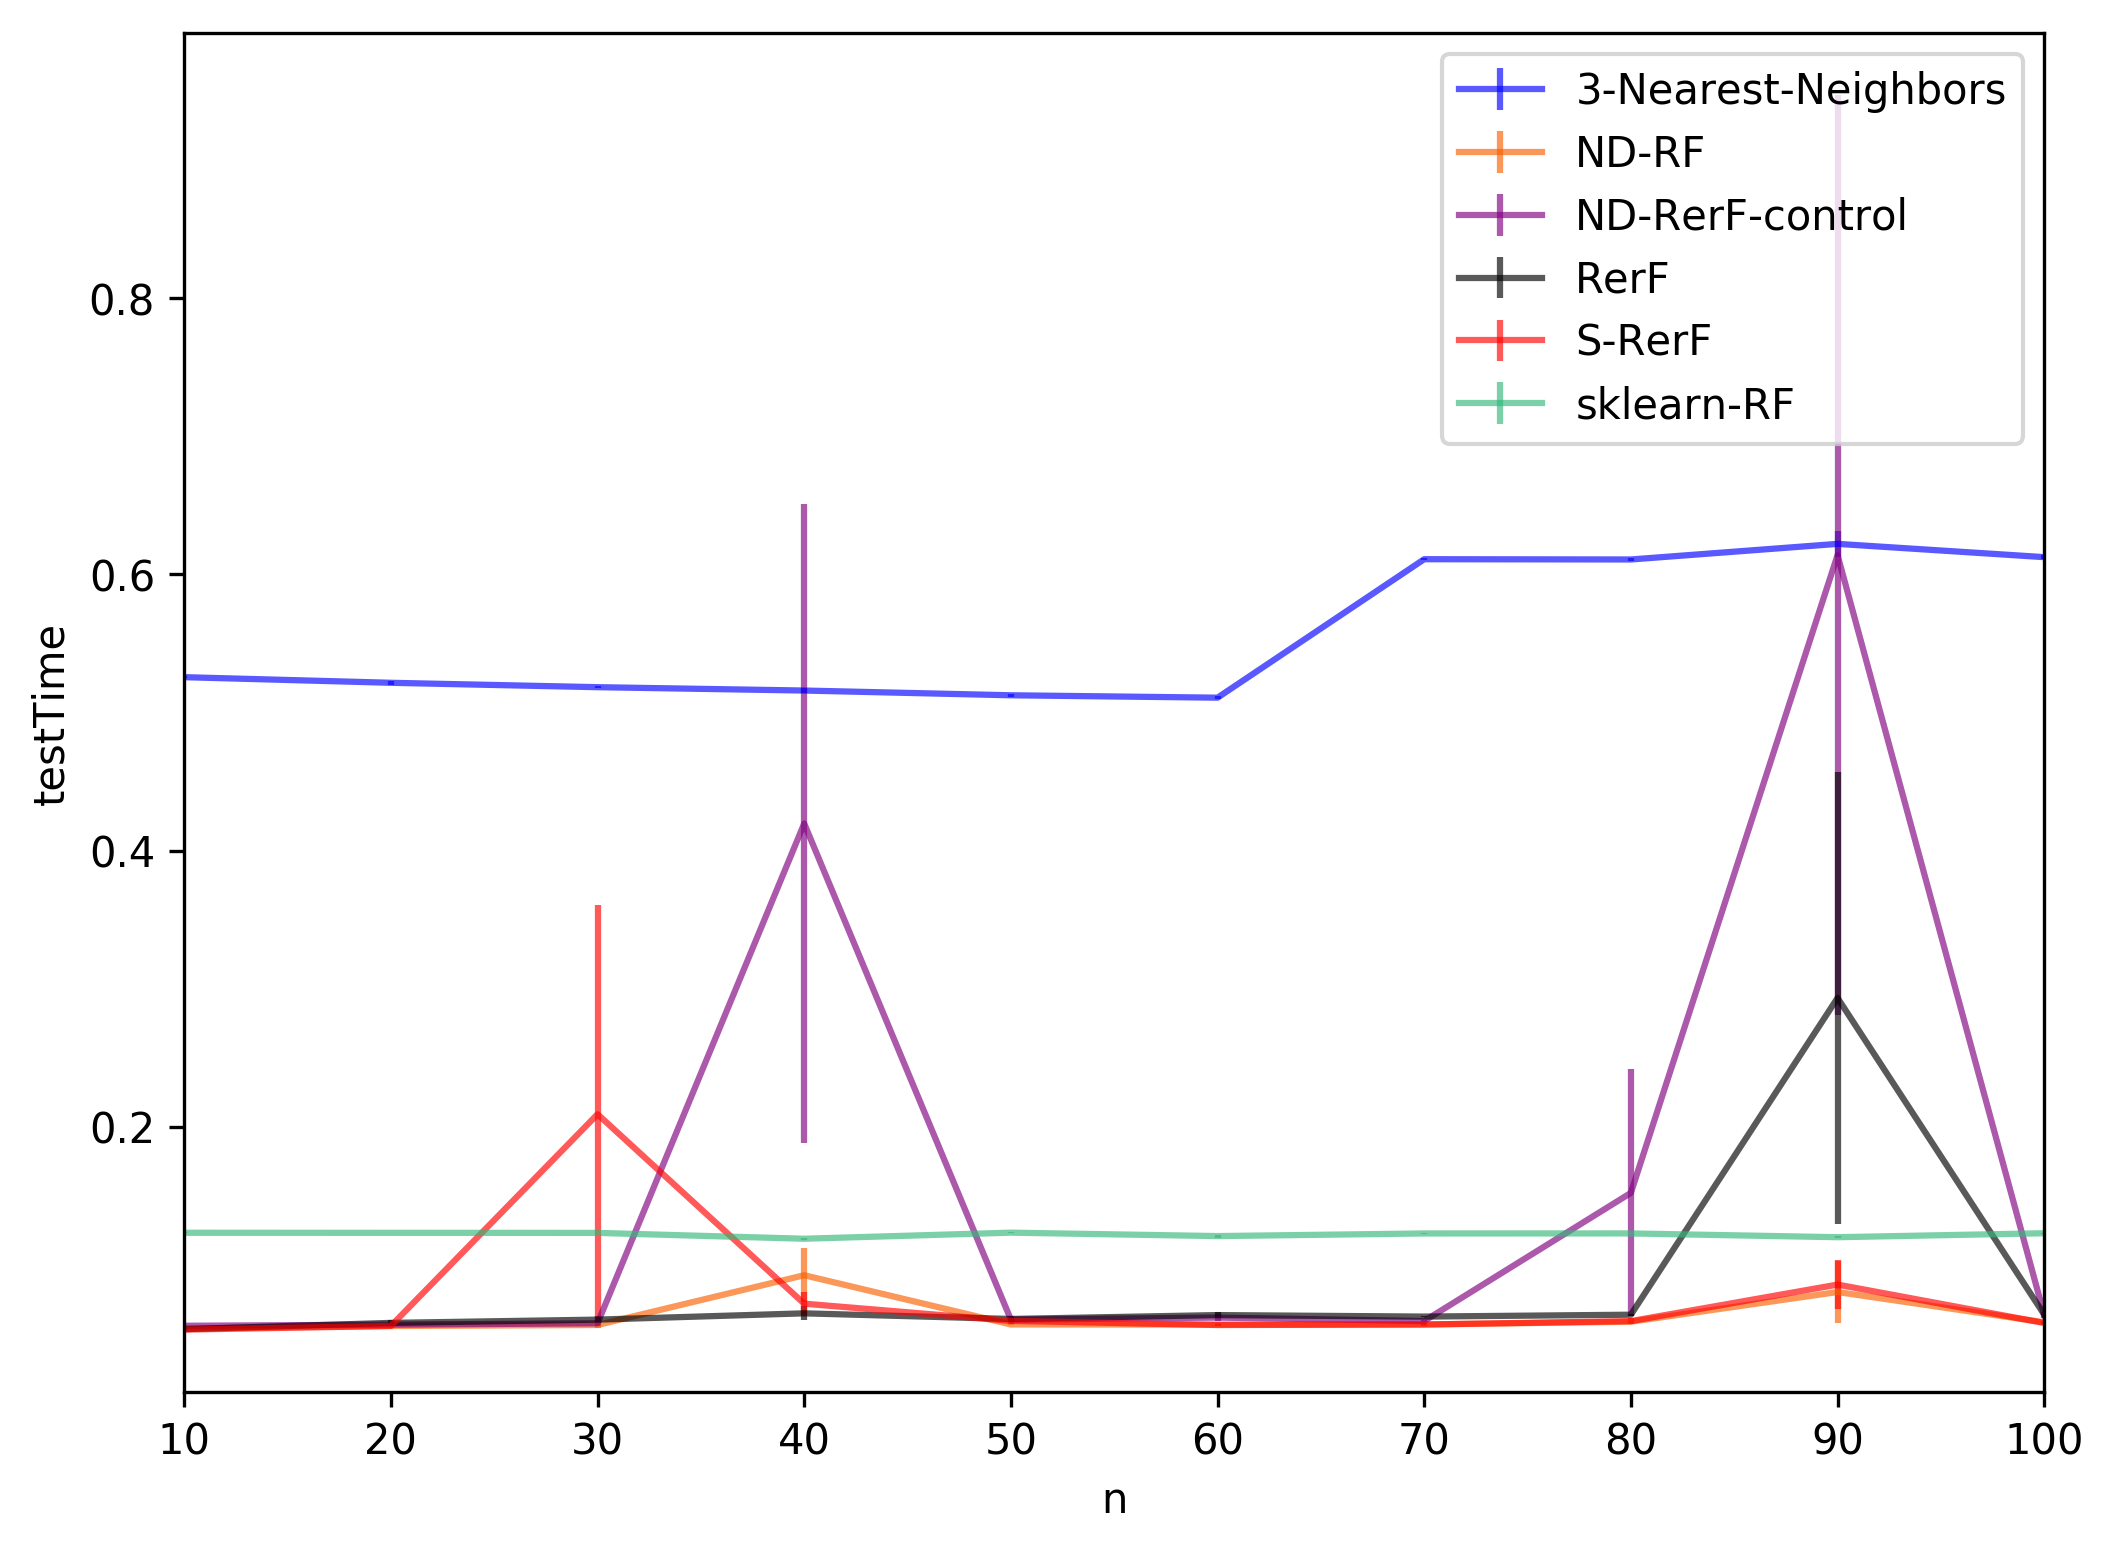

In [13]:
d1 = pd.DataFrame(columns = ['classifier', 'n', 'testTime', 'se', 'color'])

k = 0
for ni in np.unique(dat['n'])[0:10]:
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl, dat['n'] == ni)][['n', 'testTime']]

        se = stats.sem(tmp['testTime'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        k += 1

 
matplotlib.rc('figure', figsize=[12,8], dpi = 300)
fig, ax = plt.subplots(figsize = (8,6))

for key, grp in d1.groupby(['classifier']):
    ax = grp.plot(ax=ax, kind='line', x='n', y='testTime', label=key, \
            c = names[key], yerr='se', alpha =0.65)
    #ax.set_xscale('log', basex=2)
    #ax.set_yscale('log')

plt.legend(loc='best')
plt.ylabel("testTime")
plt.show()